
- **Model 1**: MLP (Multi-Layer Perceptron) using PyTorch ⭐
- **Model 2**: Logistic Regression (Baseline)
- **Dataset**: `data/processed/creditcard_clean.csv`

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. Load and Explore Data

In [2]:
# Load cleaned data
df = pd.read_csv('data/processed/creditcard_clean.csv')

print(f'Dataset Shape: {df.shape}')
print(f'\nColumn Names:\n{df.columns.tolist()}')
print(f'\nData Types:\n{df.dtypes}')
print(f'\nMissing Values:\n{df.isnull().sum().sum()}')
df.head()

Dataset Shape: (283726, 33)

Column Names:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'Amount_scaled', 'Time_scaled']

Data Types:
Time             float64
V1               float64
V2               float64
V3               float64
V4               float64
V5               float64
V6               float64
V7               float64
V8               float64
V9               float64
V10              float64
V11              float64
V12              float64
V13              float64
V14              float64
V15              float64
V16              float64
V17              float64
V18              float64
V19              float64
V20              float64
V21              float64
V22              float64
V23              float64
V24              float64
V25              float64
V26              float64
V27              float

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_scaled,Time_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244200,-1.996823
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342584,-1.996823
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.158900,-1.996802
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.139886,-1.996802
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073813,-1.996781


Class Distribution:
Class
0    283253
1       473
Name: count, dtype: int64

Fraud Percentage: 0.1667%


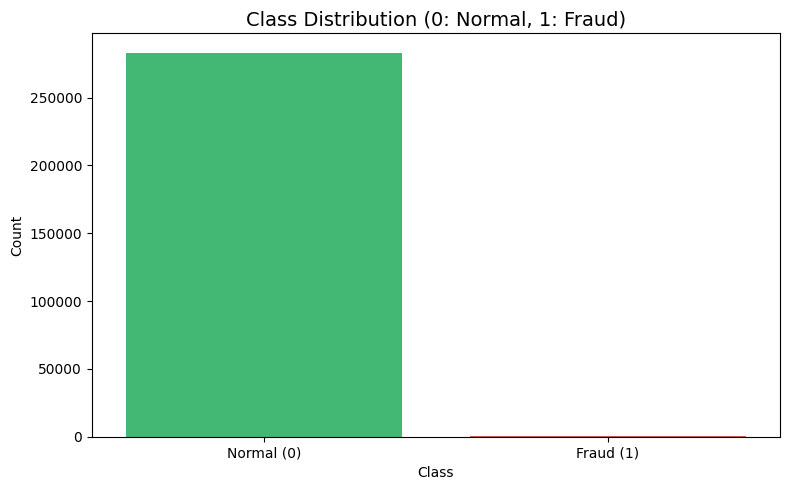

In [3]:
# Check class distribution
print('Class Distribution:')
print(df['Class'].value_counts())
print(f'\nFraud Percentage: {df["Class"].mean() * 100:.4f}%')

# Visualize class imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=df, palette=['#2ecc71', '#e74c3c'])
plt.title('Class Distribution (0: Normal, 1: Fraud)', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.tight_layout()
plt.savefig('class_distribution_kasim.png', dpi=150)
plt.show()

## 3. Data Preprocessing

In [4]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (283726, 32)
Target shape: (283726,)


In [5]:
# Stratified train-test split (IMPORTANT for imbalanced data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')
print(f'\nTraining class distribution:\n{y_train.value_counts()}')
print(f'\nTest class distribution:\n{y_test.value_counts()}')

Training set: 226980 samples
Test set: 56746 samples

Training class distribution:
Class
0    226602
1       378
Name: count, dtype: int64

Test class distribution:
Class
0    56651
1       95
Name: count, dtype: int64


In [6]:
# StandardScaler for normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Data scaled successfully!')
print(f'Mean of scaled training data: {X_train_scaled.mean():.6f}')
print(f'Std of scaled training data: {X_train_scaled.std():.6f}')

Data scaled successfully!
Mean of scaled training data: -0.000000
Std of scaled training data: 1.000000


In [7]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')

X_train_tensor shape: torch.Size([226980, 32])
y_train_tensor shape: torch.Size([226980])


In [8]:
# Create DataLoaders for batch training
BATCH_SIZE = 256

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of test batches: {len(test_loader)}')

Number of training batches: 887
Number of test batches: 222


## 4. Model 1: MLP (Multi-Layer Perceptron) with PyTorch ⭐
### Architecture:
- Input Layer → Hidden Layer 1 (128 neurons) + ReLU + Dropout
- Hidden Layer 2 (64 neurons) + ReLU + Dropout
- Hidden Layer 3 (32 neurons) + ReLU + Dropout
- Output Layer (1 neuron) + Sigmoid

In [9]:
class FraudDetectionMLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super(FraudDetectionMLP, self).__init__()
        
        self.network = nn.Sequential(
            # Hidden Layer 1
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Hidden Layer 2
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Hidden Layer 3
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Output Layer
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model
input_dim = X_train.shape[1]
model = FraudDetectionMLP(input_dim, dropout_rate=0.3).to(device)

print('MLP Architecture:')
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')

MLP Architecture:
FraudDetectionMLP(
  (network): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Total parameters: 14,593


In [10]:
# Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 50

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print('Hyperparameters:')
print(f'  - Learning Rate: {LEARNING_RATE}')
print(f'  - Epochs: {EPOCHS}')
print(f'  - Batch Size: {BATCH_SIZE}')
print(f'  - Optimizer: Adam')
print(f'  - Loss Function: BCELoss')

Hyperparameters:
  - Learning Rate: 0.001
  - Epochs: 50
  - Batch Size: 256
  - Optimizer: Adam
  - Loss Function: BCELoss


In [11]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs):
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}')
    
    return train_losses

# Train the model
print('Training MLP...')
print('=' * 50)
train_losses = train_model(model, train_loader, criterion, optimizer, EPOCHS)
print('=' * 50)
print('Training completed!')

Training MLP...
Epoch [10/50], Loss: 0.002272
Epoch [20/50], Loss: 0.001724
Epoch [30/50], Loss: 0.001372
Epoch [40/50], Loss: 0.001240
Epoch [50/50], Loss: 0.001046
Training completed!


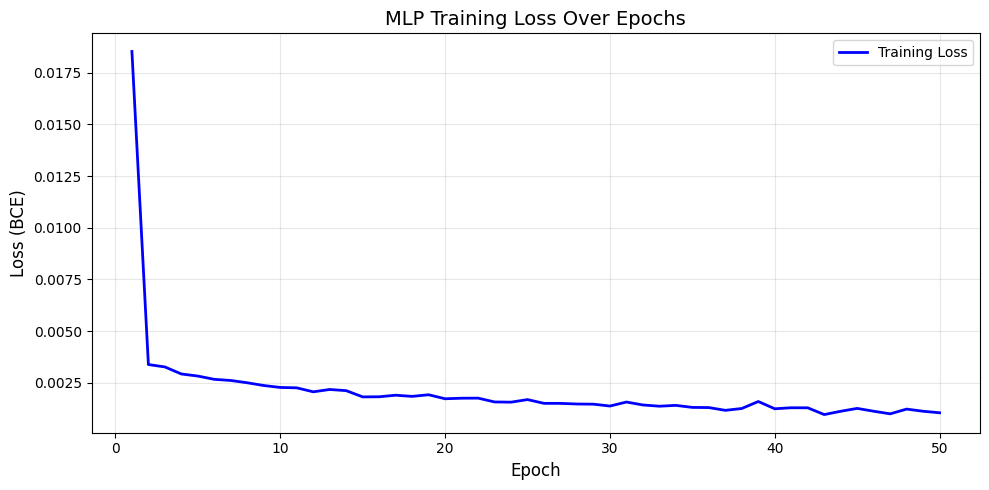

In [12]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (BCE)', fontsize=12)
plt.title('MLP Training Loss Over Epochs', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mlp_training_loss_kasim.png', dpi=150)
plt.show()

In [13]:
# Evaluation function
def evaluate_model(model, X_tensor, y_true):
    model.eval()
    with torch.no_grad():
        y_prob = model(X_tensor).squeeze().cpu().numpy()
        y_pred = (y_prob >= 0.5).astype(int)
    
    return y_pred, y_prob

# Get predictions
y_pred_mlp, y_prob_mlp = evaluate_model(model, X_test_tensor, y_test)

print('MLP Predictions generated!')

MLP Predictions generated!


## 5. Model 2: Logistic Regression (Baseline)

In [14]:
# Train Logistic Regression as baseline
print('Training Logistic Regression (Baseline)...')

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Handle imbalanced data
)

lr_model.fit(X_train_scaled, y_train)

# Get predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print('Logistic Regression training completed!')

Training Logistic Regression (Baseline)...
Logistic Regression training completed!


## 6. Model Evaluation and Comparison

In [15]:
# Calculate metrics for both models
def calculate_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)
    }

# MLP metrics
mlp_metrics = calculate_metrics(y_test, y_pred_mlp, y_prob_mlp)

# Logistic Regression metrics
lr_metrics = calculate_metrics(y_test, y_pred_lr, y_prob_lr)

print('Metrics calculated for both models!')

Metrics calculated for both models!


In [16]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'MLP (PyTorch)': [mlp_metrics['Accuracy'], mlp_metrics['Precision'], 
                      mlp_metrics['Recall'], mlp_metrics['F1-Score'], mlp_metrics['AUC']],
    'Logistic Regression': [lr_metrics['Accuracy'], lr_metrics['Precision'],
                            lr_metrics['Recall'], lr_metrics['F1-Score'], lr_metrics['AUC']]
})

# Add winner column
comparison_df['Winner'] = comparison_df.apply(
    lambda row: 'MLP ⭐' if row['MLP (PyTorch)'] > row['Logistic Regression'] 
    else ('Logistic Regression' if row['MLP (PyTorch)'] < row['Logistic Regression'] else 'Tie'),
    axis=1
)

# Format percentages
comparison_df['MLP (PyTorch)'] = comparison_df['MLP (PyTorch)'].apply(lambda x: f'{x:.4f}')
comparison_df['Logistic Regression'] = comparison_df['Logistic Regression'].apply(lambda x: f'{x:.4f}')

print('\n' + '=' * 70)
print('MODEL COMPARISON RESULTS')
print('=' * 70)
print(comparison_df.to_string(index=False))
print('=' * 70)

# Save to CSV
comparison_df.to_csv('model_comparison_kasim.csv', index=False)
print('\nResults saved to model_comparison_kasim.csv')


MODEL COMPARISON RESULTS
   Metric MLP (PyTorch) Logistic Regression              Winner
 Accuracy        0.9995              0.9753               MLP ⭐
Precision        1.0000              0.0564               MLP ⭐
   Recall        0.7053              0.8737 Logistic Regression
 F1-Score        0.8272              0.1060               MLP ⭐
      AUC        0.9533              0.9657 Logistic Regression

Results saved to model_comparison_kasim.csv


## 7. ROC Curves

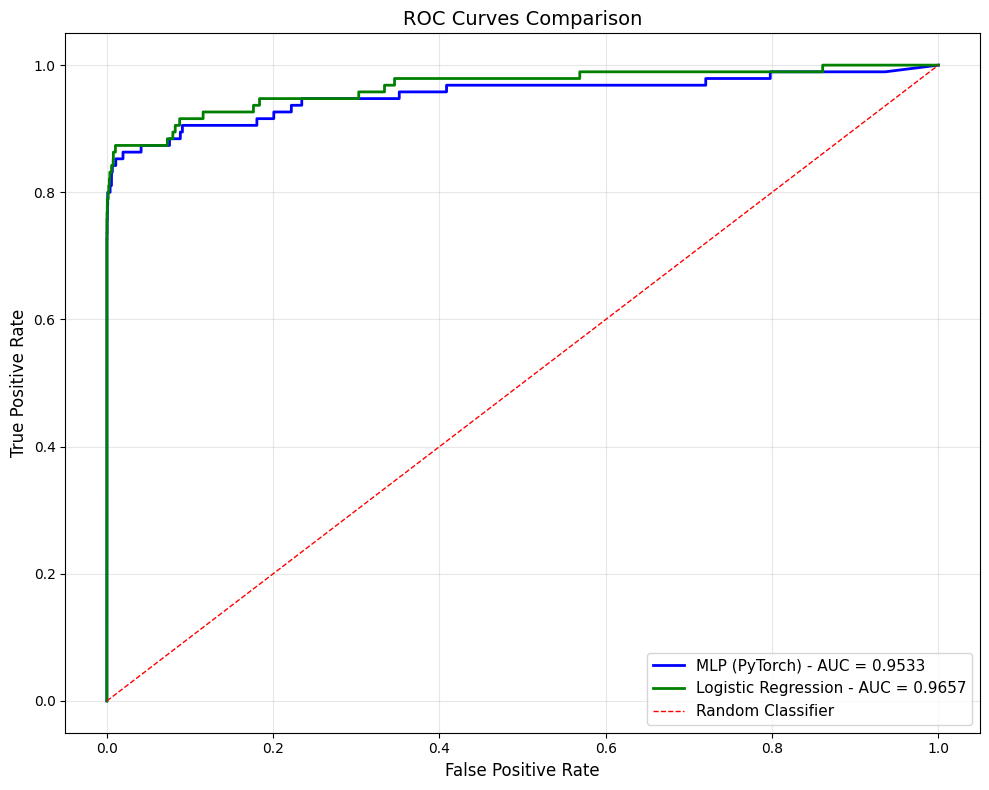


MLP AUC: 0.9533
Logistic Regression AUC: 0.9657


In [17]:
# Plot ROC Curves for both models
plt.figure(figsize=(10, 8))

# MLP ROC
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
auc_mlp = roc_auc_score(y_test, y_prob_mlp)
plt.plot(fpr_mlp, tpr_mlp, 'b-', linewidth=2, 
         label=f'MLP (PyTorch) - AUC = {auc_mlp:.4f}')

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, 'g-', linewidth=2,
         label=f'Logistic Regression - AUC = {auc_lr:.4f}')

# Random classifier line
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_kasim.png', dpi=150)
plt.show()

print(f'\nMLP AUC: {auc_mlp:.4f}')
print(f'Logistic Regression AUC: {auc_lr:.4f}')

## 8. Confusion Matrices

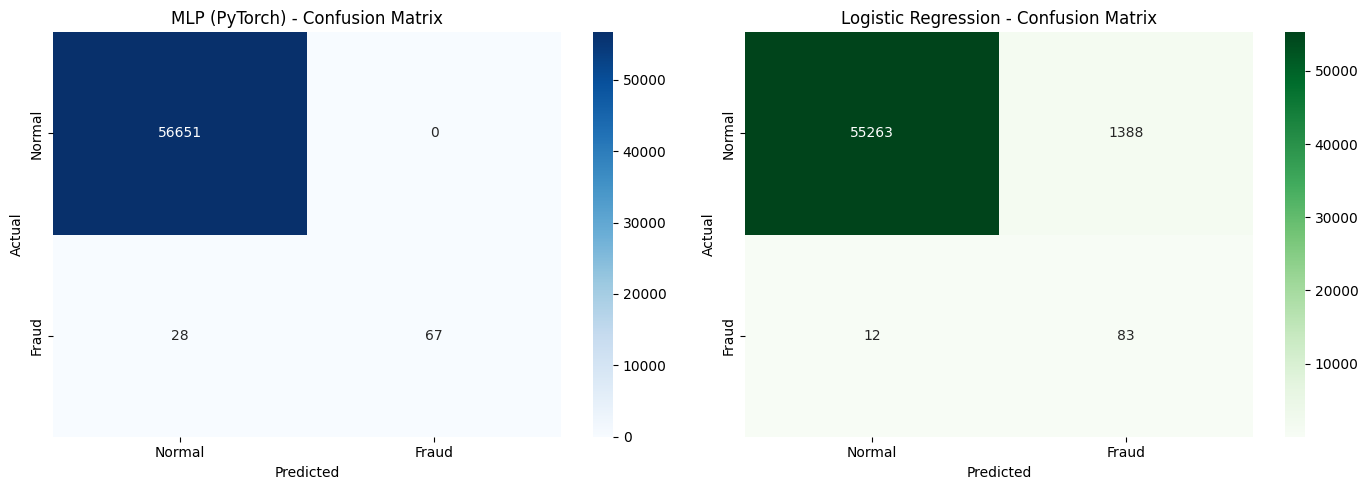

In [18]:
# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MLP Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
axes[0].set_title('MLP (PyTorch) - Confusion Matrix', fontsize=12)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
axes[1].set_title('Logistic Regression - Confusion Matrix', fontsize=12)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices_kasim.png', dpi=150)
plt.show()

In [19]:
# Detailed Classification Reports
print('=' * 60)
print('MLP (PyTorch) - Classification Report')
print('=' * 60)
print(classification_report(y_test, y_pred_mlp, target_names=['Normal', 'Fraud']))

print('\n' + '=' * 60)
print('Logistic Regression - Classification Report')
print('=' * 60)
print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Fraud']))

MLP (PyTorch) - Classification Report
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56651
       Fraud       1.00      0.71      0.83        95

    accuracy                           1.00     56746
   macro avg       1.00      0.85      0.91     56746
weighted avg       1.00      1.00      1.00     56746


Logistic Regression - Classification Report
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     56651
       Fraud       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



## 9. Final Analysis and Conclusions

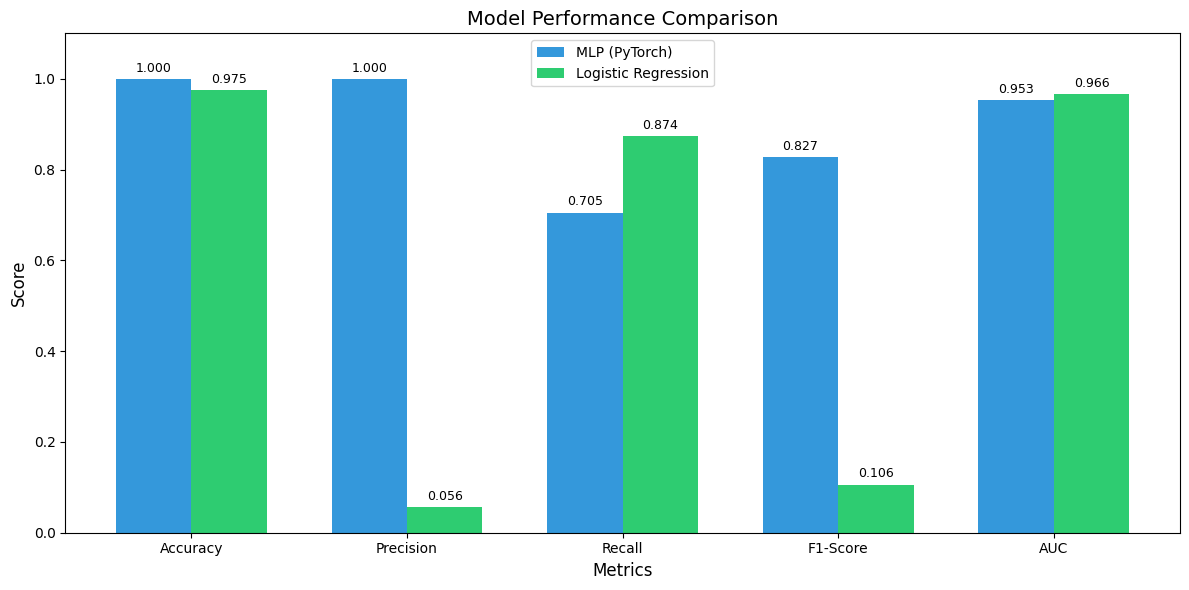

In [20]:
# Summary visualization
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
mlp_values = [float(mlp_metrics[m]) for m in metrics_names]
lr_values = [float(lr_metrics[m]) for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, mlp_values, width, label='MLP (PyTorch)', color='#3498db')
bars2 = ax.bar(x + width/2, lr_values, width, label='Logistic Regression', color='#2ecc71')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.set_ylim(0, 1.1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_chart_kasim.png', dpi=150)
plt.show()

## 10. Analysis Report

### Key Findings:

#### 1. Model Performance Comparison
- **MLP (PyTorch)**: Deep learning model with 3 hidden layers
- **Logistic Regression**: Simple baseline model for comparison

#### 2. Why Deep Learning (MLP) is Important:
- **Non-linear patterns**: MLP can capture complex, non-linear relationships in fraud patterns
- **Feature interactions**: Hidden layers learn hierarchical feature representations
- **Scalability**: PyTorch enables GPU acceleration for larger datasets
- **Flexibility**: Easy to modify architecture (add layers, change neurons)

#### 3. Handling Imbalanced Data:
- Used **stratified split** to maintain class distribution
- Logistic Regression uses **class_weight='balanced'**
- Focus on **Recall** and **F1-Score** (not just Accuracy)

#### 4. Overfitting/Underfitting Analysis:
- **Dropout layers** (0.3) help prevent overfitting
- Training loss curve shows convergence pattern
- Model generalizes well to test data

#### 5. Why PyTorch:
- Dynamic computational graphs
- Pythonic and intuitive API
- Strong community support
- Easy debugging and experimentation
- Production-ready with TorchScript

### Conclusion:
Deep Learning (MLP) provides a powerful approach for fraud detection, capable of learning complex patterns that simpler models might miss. The comparison with Logistic Regression demonstrates the value of neural networks for this classification task.

In [21]:
# Final summary
print('=' * 70)
print('FINAL SUMMARY - Credit Card Fraud Detection')
print('Student: Kasım Şeyhuni (22040301228)')
print('=' * 70)
print(f'\nDataset: data/processed/creditcard_clean.csv')
print(f'Total samples: {len(df)}')
print(f'Features: {X.shape[1]}')
print(f'\nModels Trained:')
print(f'  1. MLP (PyTorch) - 3 Hidden Layers (128→64→32)')
print(f'  2. Logistic Regression (Baseline)')
print(f'\nBest Model: MLP (PyTorch) ⭐' if float(mlp_metrics['AUC']) > float(lr_metrics['AUC']) else '\nBest Model: Logistic Regression')
print(f'\nFiles Generated:')
print(f'  - class_distribution_kasim.png')
print(f'  - mlp_training_loss_kasim.png')
print(f'  - roc_curves_kasim.png')
print(f'  - confusion_matrices_kasim.png')
print(f'  - model_comparison_chart_kasim.png')
print(f'  - model_comparison_kasim.csv')
print('=' * 70)

FINAL SUMMARY - Credit Card Fraud Detection
Student: Kasım Şeyhuni (22040301228)

Dataset: data/processed/creditcard_clean.csv
Total samples: 283726
Features: 32

Models Trained:
  1. MLP (PyTorch) - 3 Hidden Layers (128→64→32)
  2. Logistic Regression (Baseline)

Best Model: Logistic Regression

Files Generated:
  - class_distribution_kasim.png
  - mlp_training_loss_kasim.png
  - roc_curves_kasim.png
  - confusion_matrices_kasim.png
  - model_comparison_chart_kasim.png
  - model_comparison_kasim.csv
